In [37]:
import numpy as np 
import pandas as pd
import librosa
import matplotlib.pylab as plt
import IPython.display as ipd
from PIL import Image

import math
import copy
import collections as c

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [38]:
use_cuda = torch.cuda.is_available() #use GPU if available
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

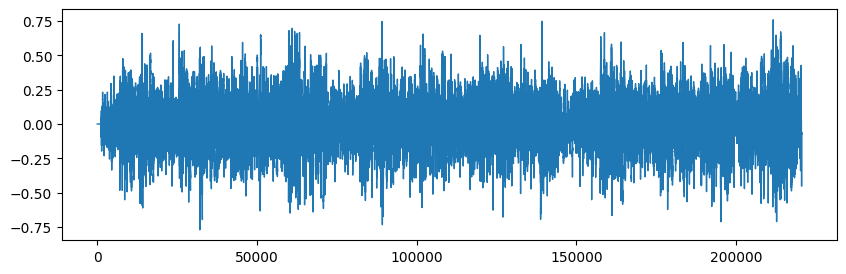

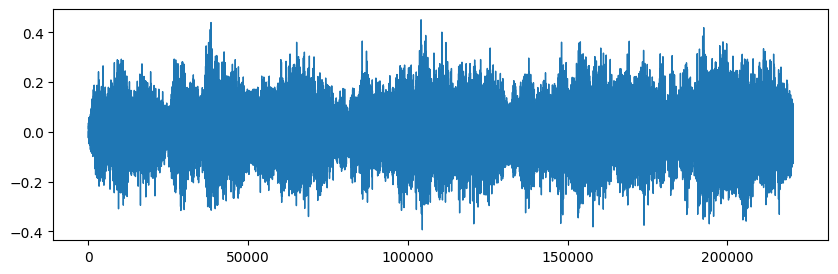

In [39]:
content_path = "input_audio/pirates.mp3"
style_path = "input_audio/starwars.mp3"

def audio_loader(path):
    audio, sr = librosa.load(path)
    if audio.__len__()>=220500:
        audio = audio[:220500] 
    display(ipd.Audio(audio, rate=22050))
    pd.Series(audio).plot(figsize=(10,3), lw=1)
    plt.show()
    return audio, sr

content, sr = audio_loader(content_path)
style, _ = audio_loader(style_path)
size = (1025, 430)

In [40]:
def Audio_transform(aud, size):
    stft = np.abs(librosa.stft(aud))
    mag, _ = librosa.magphase(stft)  
    mag = np.log1p(mag)

    mag_min, mag_max = int(math.floor(np.amin(mag))), int(math.ceil(np.amax(mag)))
    mag_norm = (mag - mag_min) / (mag_max - mag_min)
    mag_norm = mag_norm[:size[0], :size[1]]
    return mag_norm , mag_min, mag_max


def Image_to_Audio(img, mag_min, mag_max):
    mag_norm = np.array(img, dtype=np.float32) / 255
    mag = mag_norm * (mag_max - mag_min) + mag_min
    mag = np.exp(mag) - 1
    return librosa.griffinlim(mag)

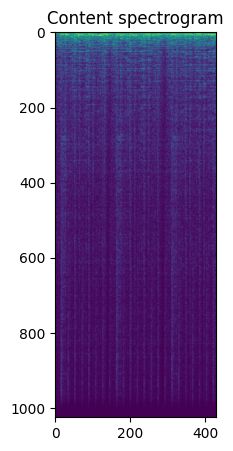

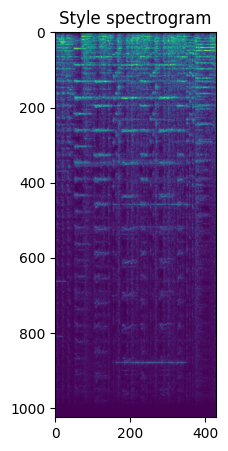

In [41]:
content_norm, mag_min, mag_max= Audio_transform(content,size)
style_norm, _, _= Audio_transform(style, size)

content_array = np.array(content_norm)[None, None, :, :]
style_array = np.array(style_norm)[None, None, :, :]
content_tensor = torch.tensor(content_array, dtype=torch.float32, requires_grad=True).permute(0,2,1,3)
style_tensor = torch.tensor(style_array, dtype=torch.float32, requires_grad=True).permute(0,2,1,3)

content_img = Variable(content_tensor).type(dtype)
style_img = Variable(style_tensor).type(dtype)

total_samples = style_norm.shape[1] #time bins
Total_Freq = style_norm.shape[0] #freq bins
total_filt=4096
filter_size=11


plt.figure(figsize=(10, 5))
plt.title('Content spectrogram')
plt.imshow(content_norm)
plt.figure(figsize=(10, 5))
plt.title('Style spectrogram')
plt.imshow(style_norm)

In [42]:
IN_CHANNELS = Total_Freq

def weights_initializer(m):
    std = np.sqrt(2) * np.sqrt(2.0 / ((Total_Freq + total_filt) * filter_size))
    kernel = torch.randn(1, 1, 1, 11) * std
    torch.manual_seed(2)
    return nn.Parameter(kernel)

class style_net(nn.Module):
    def __init__(self):
        super(style_net, self).__init__()
        self.layers = nn.Sequential(c.OrderedDict([
                            ('conv1',nn.Conv2d(IN_CHANNELS,total_filt,kernel_size=(1,filter_size),bias=False)),
                            ('relu1',nn.ReLU())]))
        
    def forward(self,input):
        out = self.layers(input)
        return out

In [43]:
cnn = style_net()

cnn.apply(weights_initializer)

for param in cnn.parameters():
    param.requires_grad = False
print(list(cnn.layers))

if use_cuda:
    cnn = cnn.cuda()

content_layers_default = ['conv_1'] 
style_layers_default = ['conv_1'] 

[Conv2d(1025, 4096, kernel_size=(1, 11), stride=(1, 1), bias=False), ReLU()]


In [44]:
class ContentLoss(nn.Module):
    
    def __init__(self, target, weight): #weight here is the epsilon tuning (how much content vs style)
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self):
        self.loss.backward(retain_graph=True)
        return self.loss

In [45]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size() 
        features = input.view(b, a * c * d)
        G = torch.mm(features, features.t())
        return G.div(a * c * d)
    
class StyleLoss(nn.Module):

    def __init__(self, target, weight): #alpha tuning (how much content vs style)
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target) #target=gram mat for style img, G=gram mat for current input ie. noise
        return self.output

    def backward(self):
        self.loss.backward(retain_graph=True)
        return self.loss

In [46]:
def get_style_model_and_losses(cnn, style_img, 
                               content_img=None,
                               style_weight=1, 
                               content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    content_losses = []
    style_losses = []
    
    model = nn.Sequential()
    layer_list =  list(cnn.layers)
    
    gram = GramMatrix() 
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    #here we rebuild the network adding the in content and style loss "layers"   
    i = 1  
    for layer in layer_list:
        
        if isinstance(layer, nn.Conv2d): #if layer in vgg19 belong to class nn.Conv2d
            name = "conv_" + str(i)
            model.add_module(name, layer) #add that layer to our sequential model
            
            if name in content_layers: #at the right depth add the content loss "layer"
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers: #at the right depth add the content loss "layer"
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU): #do the same for ReLUs
            name = "relu_" + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss) 
                
            i += 1

        if isinstance(layer, nn.MaxPool2d): #do the same for maxpool
            name = "pool_" + str(i)
            model.add_module(name, layer)
            
            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

    return model, style_losses, content_losses

In [47]:
def in_img():
    input_imgs = []    
    input_imgs.append(Variable(torch.rand(1,Total_Freq,1,total_samples)*1e-1).type(dtype))
    return input_imgs
input_imgs=in_img()

In [48]:
def get_input_param_optimizer(input_img):
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [49]:
def run_style_transfer(cnn, style_img, input_img, content_img=None, num_steps=500,
                       style_weight=1, content_weight=1):
    """Run the style transfer"""
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)
    
    print("Input range:",torch.max(input_param.data),torch.min(input_param.data))   
    print(model)
    print('Optimizing..')
    run = [0]
    
    while run[0] <= num_steps:

        def closure():
            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()

            for cl in content_losses:
                content_score += cl.backward()
            
            total_loss = style_score + content_score

            run[0] += 1
            if run[0] % 50 == 0:
                print(run[0])
                print("run {}:".format(run))
                print('Style Loss : {:4f}'.format(
                    style_score.item()))
                print('Total Loss : {:4f}'.format(
                    total_loss.item()))
                          
            return total_loss   
        
        optimizer.step(closure)

    return input_param.data

In [50]:
output = run_style_transfer(cnn, style_img, input_imgs[0], content_img)

Building the style transfer model..
Input range: tensor(0.1000, device='cuda:0') tensor(5.0664e-07, device='cuda:0')
Sequential(
  (conv_1): Conv2d(1025, 4096, kernel_size=(1, 11), stride=(1, 1), bias=False)
  (content_loss_1): ContentLoss(
    (criterion): MSELoss()
  )
  (style_loss_1): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_1): ReLU()
)
Optimizing..
50
run [50]:
Style Loss : 0.000064
Total Loss : 0.003583
100
run [100]:
Style Loss : 0.000064
Total Loss : 0.003582
150
run [150]:
Style Loss : 0.000064
Total Loss : 0.003581
200
run [200]:
Style Loss : 0.000064
Total Loss : 0.003581
250
run [250]:
Style Loss : 0.000064
Total Loss : 0.003580
300
run [300]:
Style Loss : 0.000064
Total Loss : 0.003579
350
run [350]:
Style Loss : 0.000064
Total Loss : 0.003579
400
run [400]:
Style Loss : 0.000064
Total Loss : 0.003578
450
run [450]:
Style Loss : 0.000064
Total Loss : 0.003577
500
run [500]:
Style Loss : 0.000064
Total Loss : 0.003577


<class 'torch.Tensor'>


C:\Users\vansh\AppData\Roaming\Python\Python311\site-packages\IPython\lib\display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767
C:\Users\vansh\AppData\Roaming\Python\Python311\site-packages\IPython\lib\display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


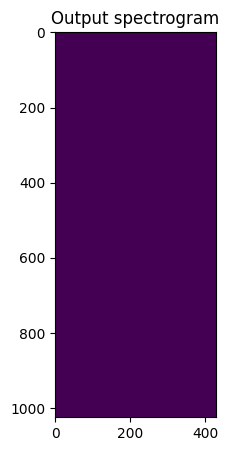

In [51]:
print(type(output))
gen_np=np.squeeze(output.detach().cpu().permute(0,2,1,3).numpy())
gen_img = Image.fromarray(gen_np).convert('L')

plt.figure(figsize=(10, 5))
plt.title('Output spectrogram')
plt.imshow(gen_img)

out_aud = Image_to_Audio(gen_img, mag_min, mag_max)
display(ipd.Audio(out_aud, rate=22050))
